In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
from tensorflow.keras import layers


from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
data_dir = pathlib.Path('./waste_classifier_dataset/')
data_dir

WindowsPath('waste_classifier_dataset')

In [3]:
batch_size = 16
img_height = 384
img_width = 512

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 5215 files belonging to 4 classes.
Using 4172 files for training.
Found 5215 files belonging to 4 classes.
Using 1043 files for validation.
['call waste', 'paper', 'recycle', 'waste']


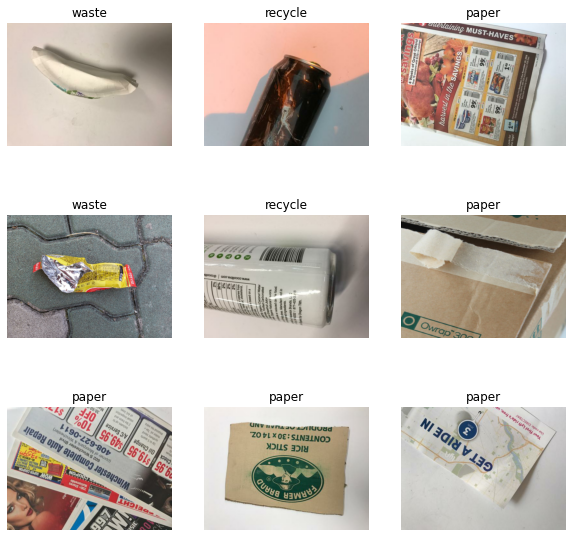

In [4]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.skip(val_batches // 5)

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

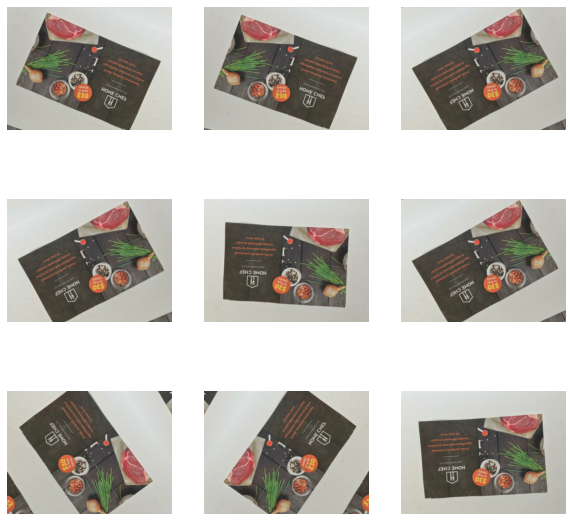

In [8]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# 1. MoblieNet

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
model_Mobile = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model_Mobile(image_batch)
print(feature_batch.shape)

(16, 12, 16, 1280)


In [13]:
model_Mobile.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [16]:
fin_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

In [17]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = model_Mobile(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer(x)
outputs = fin_layer(x)
model_Mobile = tf.keras.Model(inputs, outputs)

In [18]:
model_Mobile.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [19]:
len(model_Mobile.trainable_variables)

4

In [20]:
initial_epochs=20

In [21]:
history_Moblie = model_Mobile.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/20


C:\Users\HP\miniconda3\envs\gpu\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


261/261 [==============================] - 27s 92ms/step - loss: 0.9226 - accuracy: 0.5388 - val_loss: 0.8548 - val_accuracy: 0.5542
Epoch 2/20
261/261 [==============================] - 22s 84ms/step - loss: 0.7468 - accuracy: 0.6297 - val_loss: 0.7671 - val_accuracy: 0.5992
Epoch 3/20
261/261 [==============================] - 22s 84ms/step - loss: 0.6750 - accuracy: 0.6838 - val_loss: 0.7107 - val_accuracy: 0.6376
Epoch 4/20
261/261 [==============================] - 22s 84ms/step - loss: 0.6331 - accuracy: 0.6989 - val_loss: 0.6705 - val_accuracy: 0.6462
Epoch 5/20
261/261 [==============================] - 22s 84ms/step - loss: 0.5902 - accuracy: 0.7222 - val_loss: 0.6343 - val_accuracy: 0.6673
Epoch 6/20
261/261 [==============================] - 22s 83ms/step - loss: 0.5686 - accuracy: 0.7241 - val_loss: 0.6212 - val_accuracy: 0.6635
Epoch 7/20
261/261 [==============================] - 22s 83ms/step - loss: 0.5475 - accuracy: 0.7287 - val_loss: 0.6028 - val_accuracy: 0.6740
Epo

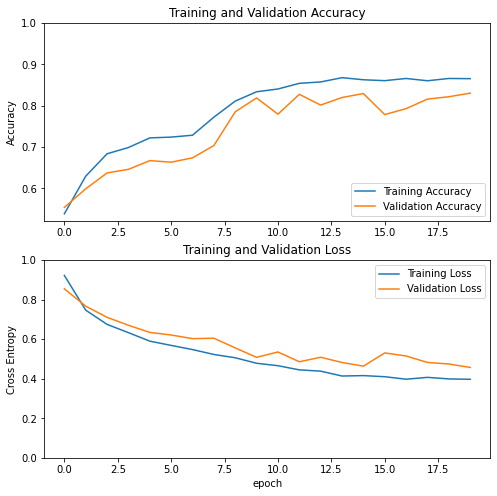

In [22]:
acc = history_Moblie.history['accuracy']
val_acc = history_Moblie.history['val_accuracy']

loss = history_Moblie.history['loss']
val_loss = history_Moblie.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<Figure size 864x288 with 0 Axes>

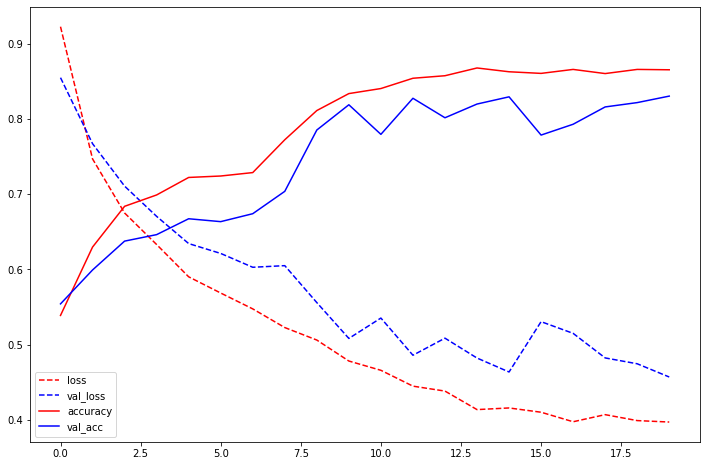

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_Moblie.history['loss'],'--',c='red')
plt.plot(history_Moblie.history['val_loss'],'--',c='blue')
plt.plot(history_Moblie.history['accuracy'],c='red')
plt.plot(history_Moblie.history['val_accuracy'],c='blue')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [24]:
model_Mobile.evaluate(val_ds)
# 손실값, 정확도

66/66 [==============================] - 4s 65ms/step - loss: 0.4570 - accuracy: 0.8303


[0.4570077955722809, 0.8302972316741943]

# 2. VGG16

##### 데이터 증강

In [25]:
IMG_SIZE = 160

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./127.5)
])

In [26]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

VGG16

In [27]:
img_shape = (img_height , img_width, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')


In [28]:
VGG16_MODEL.trainable=False     # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
VGG16_MODEL = tf.keras.Sequential([
#     resize_and_rescale,
    data_augmentation,
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])   

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/Ch14-4-bestmodel.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)


VGG16_MODEL.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])


#모델을 실행합니다
epochs = 20
history_VGG = VGG16_MODEL.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/20
261/261 [==============================] - 68s 235ms/step - loss: 0.6167 - accuracy: 0.8023 - val_loss: 0.2489 - val_accuracy: 0.9375
Epoch 2/20
261/261 [==============================] - 55s 211ms/step - loss: 0.2559 - accuracy: 0.9099 - val_loss: 0.0821 - val_accuracy: 0.9688
Epoch 3/20
261/261 [==============================] - 53s 201ms/step - loss: 0.1913 - accuracy: 0.9394 - val_loss: 0.4323 - val_accuracy: 0.8750
Epoch 4/20
261/261 [==============================] - 54s 205ms/step - loss: 0.1701 - accuracy: 0.9415 - val_loss: 0.2933 - val_accuracy: 0.9375
Epoch 5/20
261/261 [==============================] - 56s 216ms/step - loss: 0.1529 - accuracy: 0.9497 - val_loss: 0.2070 - val_accuracy: 0.9688
Epoch 6/20
261/261 [==============================] - 55s 210ms/step - loss: 0.1435 - accuracy: 0.9492 - val_loss: 0.2540 - val_accuracy: 0.8750
Epoch 7/20
261/261 [==============================] - 55s 212ms/step - loss: 0.1436 - accuracy: 0.9497 - val_loss: 0.2190 - val_ac

<Figure size 864x288 with 0 Axes>

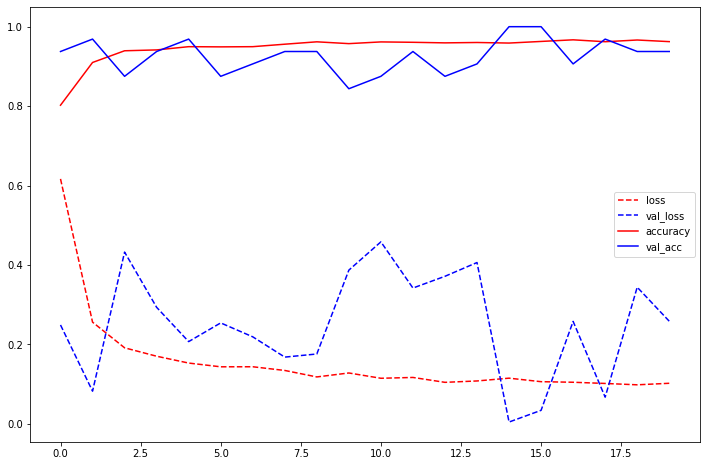

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_VGG.history['loss'],'--',c='red')
plt.plot(history_VGG.history['val_loss'],'--',c='blue')
plt.plot(history_VGG.history['accuracy'],c='red')
plt.plot(history_VGG.history['val_accuracy'],c='blue')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [31]:
VGG16_MODEL.evaluate(val_ds)
# 손실값, 정확도

66/66 [==============================] - 14s 212ms/step - loss: 0.2197 - accuracy: 0.9338


[0.21972988545894623, 0.9338446855545044]

# 3. CNN

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

model_CNN = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [33]:
model_CNN.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [34]:
history_CNN = model_CNN.fit(train_ds, validation_data=(val_ds), epochs=10)

Epoch 1/10
261/261 [==============================] - 25s 84ms/step - loss: 0.9773 - accuracy: 0.5429 - val_loss: 0.8200 - val_accuracy: 0.6146
Epoch 2/10
261/261 [==============================] - 20s 76ms/step - loss: 0.7434 - accuracy: 0.6870 - val_loss: 0.6260 - val_accuracy: 0.7354
Epoch 3/10
261/261 [==============================] - 20s 76ms/step - loss: 0.6479 - accuracy: 0.7366 - val_loss: 0.6615 - val_accuracy: 0.7267
Epoch 4/10
261/261 [==============================] - 20s 75ms/step - loss: 0.5430 - accuracy: 0.7910 - val_loss: 0.5906 - val_accuracy: 0.7306
Epoch 5/10
261/261 [==============================] - 20s 75ms/step - loss: 0.4875 - accuracy: 0.8102 - val_loss: 0.6123 - val_accuracy: 0.7536
Epoch 6/10
261/261 [==============================] - 20s 75ms/step - loss: 0.4134 - accuracy: 0.8382 - val_loss: 0.5348 - val_accuracy: 0.7776
Epoch 7/10
261/261 [==============================] - 20s 75ms/step - loss: 0.3341 - accuracy: 0.8667 - val_loss: 0.7198 - val_accuracy:

In [35]:
model_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 384, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 382, 510, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 191, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 189, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 94, 126, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 124, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 46, 62, 64)       

<Figure size 864x288 with 0 Axes>

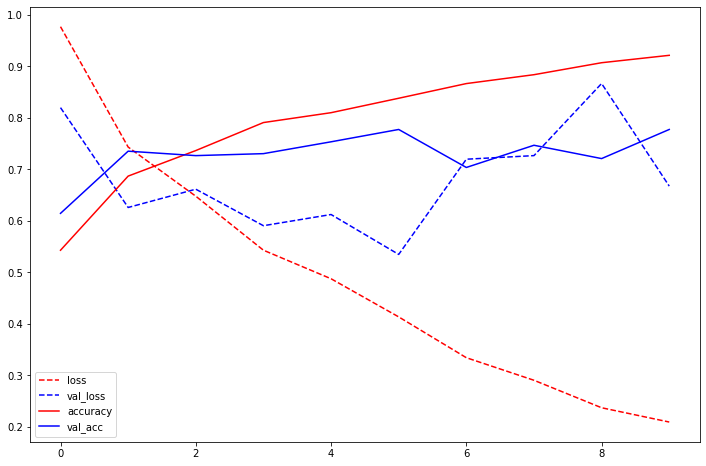

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_CNN.history['loss'],'--',c='red')
plt.plot(history_CNN.history['val_loss'],'--',c='blue')
plt.plot(history_CNN.history['accuracy'],c='red')
plt.plot(history_CNN.history['val_accuracy'],c='blue')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [37]:
model_CNN.evaluate(val_ds)
# 손실값, 정확도

66/66 [==============================] - 2s 25ms/step - loss: 0.6675 - accuracy: 0.7776


[0.6674906015396118, 0.7775647044181824]

# 혼돈행렬

In [38]:
test_all_label=[]; test_all_image=[]
for test_img, test_label in val_ds:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

((1043,), (1043, 384, 512, 3))

In [39]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [40]:
from tqdm import tqdm

In [41]:
result_MobileNet_v2=[]
for img in tqdm(test_all_image):
    softmax=model_Mobile.predict(img.reshape(1,img_height,img_width,3))
    result_MobileNet_v2.append(np.argmax(softmax))

100%|██████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:44<00:00, 23.60it/s]


In [42]:
result_VGG=[]
for img in tqdm(test_all_image):
    softmax=VGG16_MODEL.predict(img.reshape(1,img_height,img_width,3))
    result_VGG.append(np.argmax(softmax))

100%|██████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:49<00:00, 21.23it/s]


In [43]:
result_CNN=[]
for img in tqdm(test_all_image):
    softmax=model_CNN.predict(img.reshape(1,img_height,img_width,3))
    result_CNN.append(np.argmax(softmax))

100%|██████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:43<00:00, 24.25it/s]


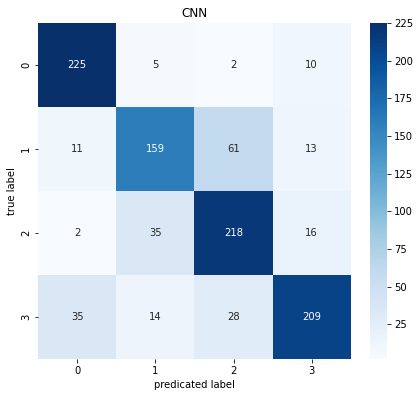

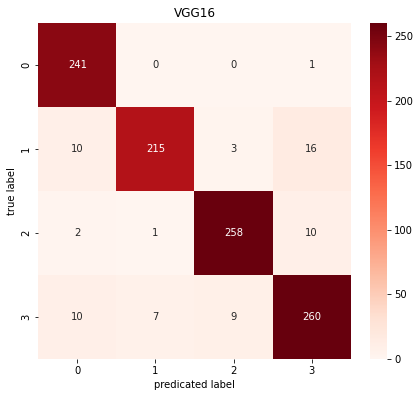

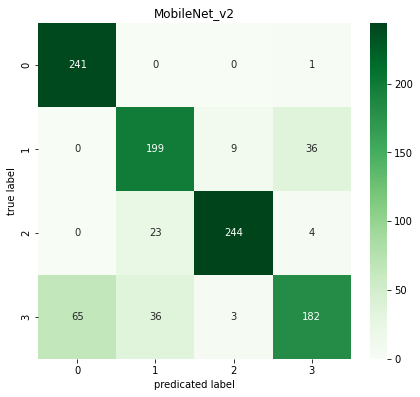

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#혼돈행렬만들기
plt.figure(figsize=(7,21))
plt.subplot(3,1,1)
plt.title('CNN')
cm=confusion_matrix(test_all_label, result_CNN)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()

plt.subplot(3,1,2)
plt.title('VGG16')
cm=confusion_matrix(test_all_label, result_VGG)
sns.heatmap(cm, annot=True, fmt='d',cmap='Reds')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()

plt.subplot(3,1,3)
plt.title('MobileNet_v2')
cm=confusion_matrix(test_all_label, result_MobileNet_v2)
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()